# <a name="C1"><font color='Blue'><h1><center>I. Import package nécessaire</center></h1></font></a>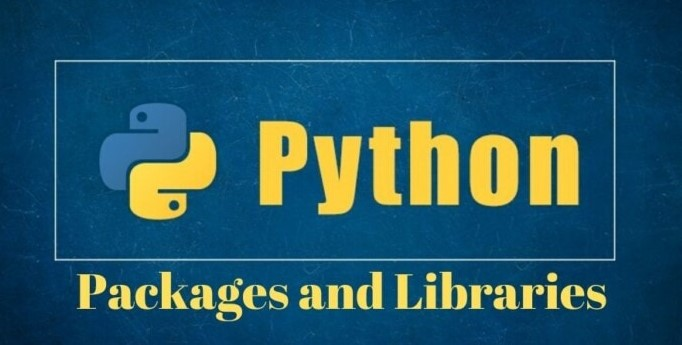

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import deepcopy
import joblib
from function_utils import *

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
%matplotlib inline
from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style = "darkgrid")

In [4]:
convertMillis(4564826.023)

'52D : 20h : 0min : 26s'

</Br>

</Br>

# <a name="C2"><font color='orange'><h1><center>II. Import Dataset</center></h1></font></a>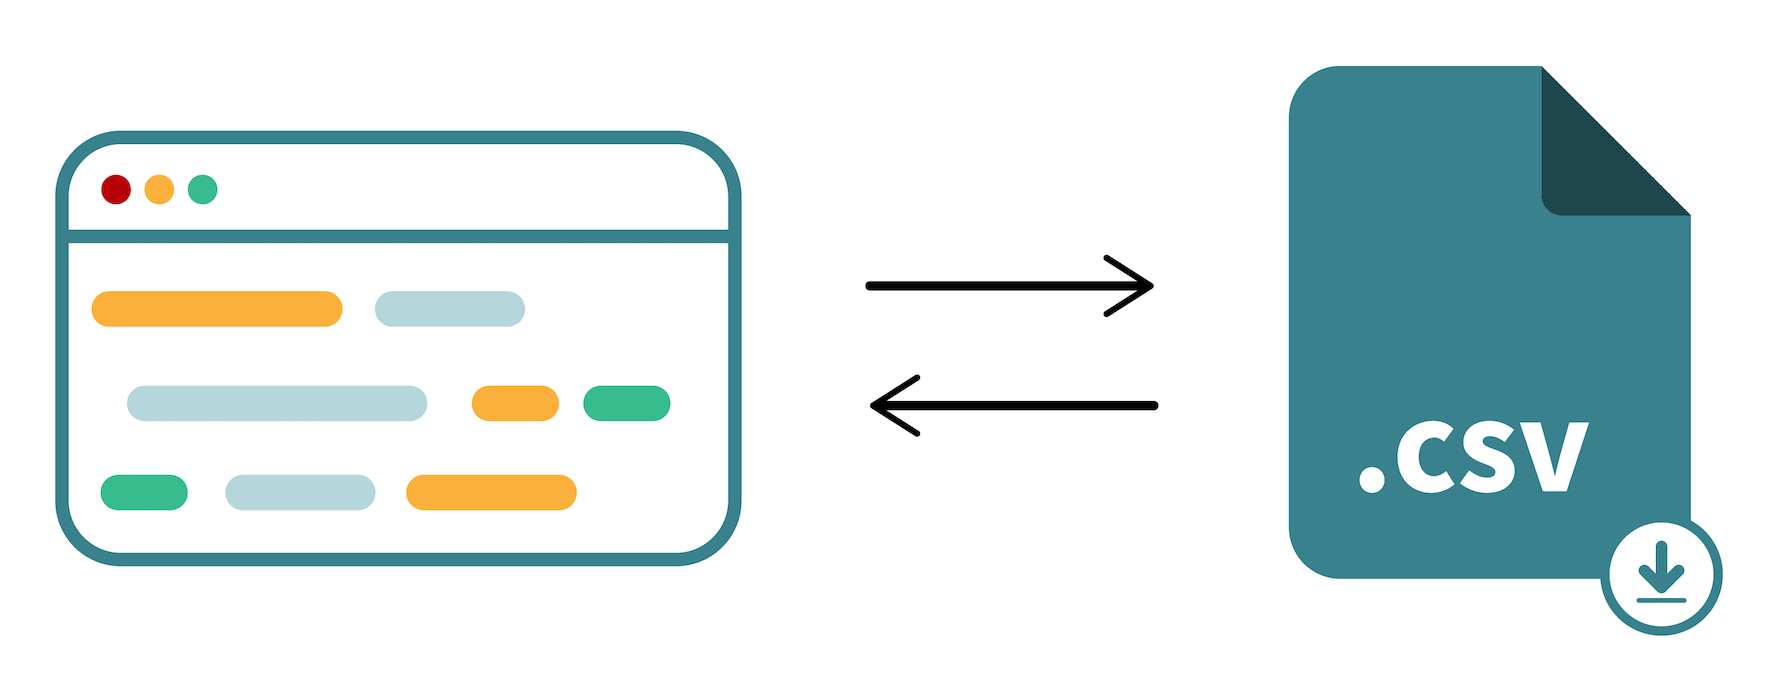

In [5]:
df = pd.read_csv('data/source/application_train.csv')
test_df = pd.read_csv('data/source/application_test.csv')

In [6]:
def clean_data1(data):
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    data = data[data['CODE_GENDER'] != 'XNA']

    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        data[bin_feature], uniques = pd.factorize(data[bin_feature])
    # Categorical features with One-Hot encode
    #df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    #data['DAYS_EMPLOYED_PERC'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['INCOME_CREDIT_PERC'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
    data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['ANNUITY_INCOME_PERC'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['PAYMENT_RATE'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    data['PERC_CREDIT_GOODS_PRICE'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
    
    # revenu par enfant
    data['INCOME_PER_CHILDREN'] = data['AMT_INCOME_TOTAL'] / (data['CNT_CHILDREN']+1)

    # ratio d'enfant
    data['CHIDREN_RATE'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']

    # ratio defaillance
    data['DEF_30_RATE'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] / data['OBS_30_CNT_SOCIAL_CIRCLE']
    data['DEF_60_RATE'] = data['DEF_60_CNT_SOCIAL_CIRCLE'] / data['OBS_60_CNT_SOCIAL_CIRCLE']

    return data

In [7]:
df = clean_data1(df)
test_df = clean_data1(test_df)

## <font color='orange'> * Import sauvegarde dataset</font>

In [8]:
if 'df' not in locals():
    print("Le dataset sera importé à partir d'une sauvegarde .csv")
    df = pd.read_csv('data/cleaned/df_cleaned.csv',sep=';')

In [9]:
df.shape

(307507, 131)

In [10]:
import joblib
important_features = joblib.load('data/cleaned/list_col_to_keep_from_train_application_final.joblib')

In [11]:
df = df[ important_features]
test_df = test_df[[f for f in important_features if f != 'TARGET']]

In [12]:
df.head()

,SK_ID_CURR,TARGET,FLAG_OWN_CAR,DAYS_REGISTRATION,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_QRT,NAME_EDUCATION_TYPE,EXT_SOURCE_3,NAME_CONTRACT_TYPE,INCOME_CREDIT_PERC,...,INCOME_PER_CHILDREN,EXT_SOURCE_2,FLAG_DOCUMENT_18,AMT_ANNUITY,PERC_CREDIT_GOODS_PRICE,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,AMT_REQ_CREDIT_BUREAU_MON,AMT_CREDIT,DAYS_LAST_PHONE_CHANGE
0,100002,1,0,-3648.0,351000.0,0.0,Secondary / secondary special,0.139376,Cash loans,0.498036,...,202500.0,0.262949,0,24700.5,1.158397,0,0,0.0,406597.5,-1134.0
1,100003,0,0,-1186.0,1129500.0,0.0,Higher education,NaN,Cash loans,0.208736,...,270000.0,0.622246,0,35698.5,1.145199,0,0,0.0,1293502.5,-828.0
2,100004,0,1,-4260.0,135000.0,0.0,Secondary / secondary special,0.729567,Revolving loans,0.500000,...,67500.0,0.555912,0,6750.0,1.000000,0,0,0.0,135000.0,-815.0
3,100006,0,0,-9833.0,297000.0,NaN,Secondary / secondary special,NaN,Cash loans,0.431748,...,135000.0,0.650442,0,29686.5,1.052803,0,0,NaN,312682.5,-617.0
4,100007,0,0,-4311.0,513000.0,0.0,Secondary / secondary special,NaN,Cash loans,0.236842,...,121500.0,0.322738,0,21865.5,1.000000,0,0,0.0,513000.0,-1106.0


</Br>

</Br>

# <a name="C3"><font color='green'><h1><center>III. Machine Learnig</center></h1></font></a>

## <a name="C31"><font color='green'>III.1 packages nécessaires modélisation</font></a>
</Br>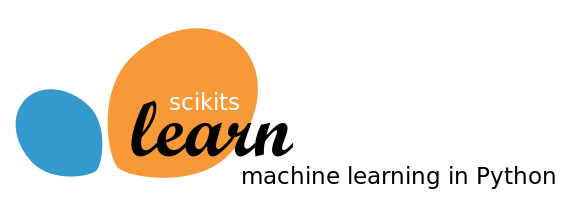

In [13]:
# Modelisation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (HistGradientBoostingClassifier, 
                              GradientBoostingClassifier,
                              RandomForestClassifier, 
                              AdaBoostClassifier)

from lightgbm import LGBMClassifier as lgbmc
from sklearn import dummy

# Cross-Validation
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

# Metrics
from sklearn.metrics import (roc_auc_score, f1_score, recall_score, 
                             accuracy_score, log_loss ,precision_score,
                            roc_curve, ConfusionMatrixDisplay )

# pipeline data transformation
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.preprocessing import OneHotEncoder,StandardScaler

</Br>

</Br>

## <a name="C32"><font color='green'>III.2 Train test Validation split</font></a>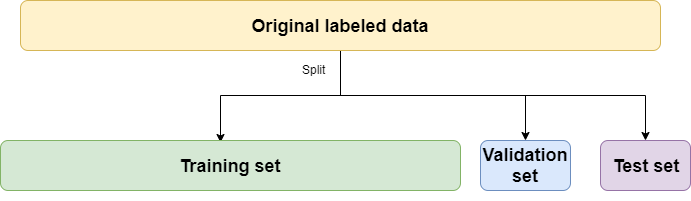

In [14]:
X = df.drop(columns=['TARGET','SK_ID_CURR'])
y = df['TARGET']

## inf
X[X==np.inf] = np.nan

random_seed = 971

# Le dataset est grand on peut diviser le données en train test valiation 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=random_seed,stratify=y) #~~100000 samples
X_test, X_validation, y_test, y_validation = train_test_split( X_test, y_test, test_size=0.5, random_state=random_seed,stratify=y_test) 

print('Le dataset Train se compose de: {0} lignes et {1} colonnes'.format( X_train.shape[0],X_train.shape[1]) )
print('Le dataset Test se compose de: {0} lignes et {1} colonnes'.format( X_test.shape[0],X_test.shape[1]) )
print('Le dataset Validation se compose de: {0} lignes et {1} colonnes'.format(X_validation.shape[0], X_validation.shape[1]) )

Le dataset Train se compose de: 215254 lignes et 36 colonnes
Le dataset Test se compose de: 46126 lignes et 36 colonnes
Le dataset Validation se compose de: 46127 lignes et 36 colonnes


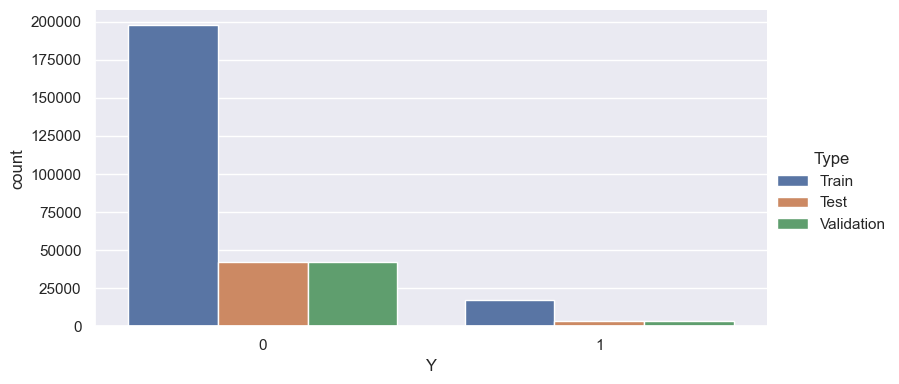

In [15]:
graphData = pd.concat([
    pd.DataFrame(np.c_[y_train,['Train' for x in y_train]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_test,['Test' for x in y_test]],columns=['Y','Type'] ),
    pd.DataFrame(np.c_[y_validation,['Validation' for x in y_validation]],columns=['Y','Type'] )],
    axis=0)

graphData.Y=graphData.Y.astype(np.int16)

sns.catplot(data=graphData, kind='count', x='Y', height=4, aspect=2,hue='Type');

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215254 entries, 81522 to 379
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FLAG_OWN_CAR                215254 non-null  int64  
 1   DAYS_REGISTRATION           215254 non-null  float64
 2   AMT_GOODS_PRICE             215058 non-null  float64
 3   AMT_REQ_CREDIT_BUREAU_QRT   186248 non-null  float64
 4   NAME_EDUCATION_TYPE         215254 non-null  object 
 5   EXT_SOURCE_3                172591 non-null  float64
 6   NAME_CONTRACT_TYPE          215254 non-null  object 
 7   INCOME_CREDIT_PERC          215254 non-null  float64
 8   DAYS_BIRTH                  215254 non-null  int64  
 9   FLAG_WORK_PHONE             215254 non-null  int64  
 10  NAME_INCOME_TYPE            215254 non-null  object 
 11  DAYS_EMPLOYED               176642 non-null  float64
 12  FLAG_DOCUMENT_8             215254 non-null  int64  
 13  REGION_POPULA

In [18]:
X_train.isna().sum()/X_train.shape[0]

FLAG_OWN_CAR                  0.000000
DAYS_REGISTRATION             0.000000
AMT_GOODS_PRICE               0.000911
AMT_REQ_CREDIT_BUREAU_QRT     0.134752
NAME_EDUCATION_TYPE           0.000000
EXT_SOURCE_3                  0.198198
NAME_CONTRACT_TYPE            0.000000
INCOME_CREDIT_PERC            0.000000
DAYS_BIRTH                    0.000000
FLAG_WORK_PHONE               0.000000
NAME_INCOME_TYPE              0.000000
DAYS_EMPLOYED                 0.179379
FLAG_DOCUMENT_8               0.000000
REGION_POPULATION_RELATIVE    0.000000
ANNUITY_INCOME_PERC           0.000051
REG_CITY_NOT_WORK_CITY        0.000000
DAYS_ID_PUBLISH               0.000000
AMT_INCOME_TOTAL              0.000000
FLAG_CONT_MOBILE              0.000000
FLAG_DOCUMENT_16              0.000000
PAYMENT_RATE                  0.000051
OCCUPATION_TYPE               0.312947
NAME_FAMILY_STATUS            0.000000
CODE_GENDER                   0.000000
FLAG_DOCUMENT_3               0.000000
ORGANIZATION_TYPE        

</Br>

</Br>

</Br>

## <a name="C33"><font color='green'>III.3 Création pipeline preprocessing data</font></a>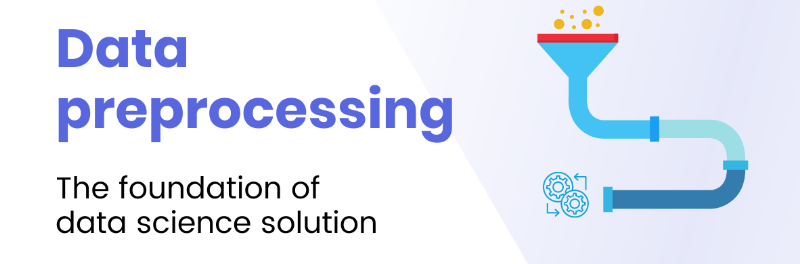

In [19]:

def intermediaire_pipe_pretraitement(X_train,model):
    """
    Fonction qui crée un pipeline, en prétraitant les données en amont puis
    en appliquant un model à la fin

    Args:
        X_train (pandas.core.frame.DataFrame): Training Dataset.
        model (type): model de type sklearn. C'est à dire possedant la méthode fit

    Returns:
        type: Description de la valeur de retour.

    Raises:
        ErrorType: Description de l'erreur éventuellement levée.

    Examples:
        Exemples d'utilisation de la fonction.
    """    
    #Numerical featues
    numeric_features = make_column_selector(dtype_include=np.float64)
    numeric_transformer = Pipeline(
        steps=[('impNumerical', SimpleImputer(strategy="median")) ]
    )

    #Discretes features
    discret_features = make_column_selector(dtype_include=np.int64)
    discret_transformer = Pipeline(
        steps=[('impDiscret', SimpleImputer(strategy = 'most_frequent')) ]
    )

    # categorials features
    categorical_features = make_column_selector(dtype_include="object")
    categorical_transformer = Pipeline(
        steps=[
            ('impCat', SimpleImputer(strategy = 'most_frequent')),
            ('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'ignore',sparse=False)),
        ])

    # columntransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num",  numeric_transformer, numeric_features),
            ("disc", discret_transformer, discret_features),
            ("cat",  categorical_transformer, categorical_features),
        ])

    # pipeline
    intermediaire_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model",model)]
    )
    
    return intermediaire_pipeline

In [20]:
# Entraîner le pipeline sur les données d'entraînement
intermediaire_pipeline = intermediaire_pipe_pretraitement( X_train,StandardScaler() )
#intermediaire_pipeline = overSamplingFunction( X_train,StandardScaler() )
    
# Application pipeline    
X_train_pt = pd.DataFrame(intermediaire_pipeline.fit_transform(X_train),
                          columns=intermediaire_pipeline.get_feature_names_out()
                         )

In [21]:
intermediaire_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impNumerical',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000014BE69AA190>),
                                                 ('disc',
                                                  Pipeline(steps=[('impDiscret',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000014BE6997710>),
                                                 ('cat',
                                                  Pipeline(steps=[('impCat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000014B929D60D0>)])),
                ('model', StandardScaler())])

In [22]:
X_train_pt.head()

,num__DAYS_REGISTRATION,num__AMT_GOODS_PRICE,num__AMT_REQ_CREDIT_BUREAU_QRT,num__EXT_SOURCE_3,num__INCOME_CREDIT_PERC,num__DAYS_EMPLOYED,num__REGION_POPULATION_RELATIVE,num__ANNUITY_INCOME_PERC,num__AMT_INCOME_TOTAL,num__PAYMENT_RATE,...,cat__ORGANIZATION_TYPE_Trade: type 4,cat__ORGANIZATION_TYPE_Trade: type 5,cat__ORGANIZATION_TYPE_Trade: type 6,cat__ORGANIZATION_TYPE_Trade: type 7,cat__ORGANIZATION_TYPE_Transport: type 1,cat__ORGANIZATION_TYPE_Transport: type 2,cat__ORGANIZATION_TYPE_Transport: type 3,cat__ORGANIZATION_TYPE_Transport: type 4,cat__ORGANIZATION_TYPE_University,cat__ORGANIZATION_TYPE_XNA
0,1.022546,-0.240315,-0.286894,-0.991257,0.402122,0.453656,0.309525,-0.994410,1.111520,-0.315798,...,-0.014935,-0.011608,-0.045,-0.161476,-0.026319,-0.084943,-0.061611,-0.13301,-0.065837,-0.467535
1,1.294713,-0.544561,-0.286894,-2.269847,0.197750,-2.357397,0.309525,-0.371786,-0.100237,0.637191,...,-0.014935,-0.011608,-0.045,-0.161476,-0.026319,-0.084943,-0.061611,-0.13301,-0.065837,-0.467535
2,-0.570118,-0.240315,-0.286894,0.111851,-0.056165,0.876951,1.830912,-0.846248,0.505641,-0.685655,...,-0.014935,-0.011608,-0.045,-0.161476,-0.026319,-0.084943,-0.061611,-0.13301,-0.065837,-0.467535
3,0.557758,-0.727109,-0.286894,-1.092198,2.217193,-1.479469,-0.012079,-0.925727,1.515439,2.422354,...,-0.014935,-0.011608,-0.045,-0.161476,-0.026319,-0.084943,-0.061611,-0.13301,-0.065837,-0.467535
4,-0.014987,0.854973,-0.286894,-0.021980,-0.626114,0.852629,-0.716342,0.124106,0.182506,-0.808056,...,-0.014935,-0.011608,-0.045,-0.161476,-0.026319,-0.084943,-0.061611,-0.13301,-0.065837,-0.467535


In [23]:
X_train_pt.filter(regex='^cat', axis=1).head()

,cat__NAME_EDUCATION_TYPE_Higher education,cat__NAME_EDUCATION_TYPE_Incomplete higher,cat__NAME_EDUCATION_TYPE_Lower secondary,cat__NAME_EDUCATION_TYPE_Secondary / secondary special,cat__NAME_CONTRACT_TYPE_Revolving loans,cat__NAME_INCOME_TYPE_Commercial associate,cat__NAME_INCOME_TYPE_Maternity leave,cat__NAME_INCOME_TYPE_Pensioner,cat__NAME_INCOME_TYPE_State servant,cat__NAME_INCOME_TYPE_Student,...,cat__ORGANIZATION_TYPE_Trade: type 4,cat__ORGANIZATION_TYPE_Trade: type 5,cat__ORGANIZATION_TYPE_Trade: type 6,cat__ORGANIZATION_TYPE_Trade: type 7,cat__ORGANIZATION_TYPE_Transport: type 1,cat__ORGANIZATION_TYPE_Transport: type 2,cat__ORGANIZATION_TYPE_Transport: type 3,cat__ORGANIZATION_TYPE_Transport: type 4,cat__ORGANIZATION_TYPE_University,cat__ORGANIZATION_TYPE_XNA
0,-0.567526,-0.186162,-0.112091,0.639154,-0.324055,-0.551162,-0.003733,-0.467432,-0.275566,-0.008348,...,-0.014935,-0.011608,-0.045,-0.161476,-0.026319,-0.084943,-0.061611,-0.13301,-0.065837,-0.467535
1,-0.567526,-0.186162,-0.112091,0.639154,-0.324055,-0.551162,-0.003733,-0.467432,-0.275566,-0.008348,...,-0.014935,-0.011608,-0.045,-0.161476,-0.026319,-0.084943,-0.061611,-0.13301,-0.065837,-0.467535
2,-0.567526,-0.186162,-0.112091,0.639154,-0.324055,1.814349,-0.003733,-0.467432,-0.275566,-0.008348,...,-0.014935,-0.011608,-0.045,-0.161476,-0.026319,-0.084943,-0.061611,-0.13301,-0.065837,-0.467535
3,1.762035,-0.186162,-0.112091,-1.564567,-0.324055,-0.551162,-0.003733,-0.467432,-0.275566,-0.008348,...,-0.014935,-0.011608,-0.045,-0.161476,-0.026319,-0.084943,-0.061611,-0.13301,-0.065837,-0.467535
4,-0.567526,-0.186162,-0.112091,0.639154,-0.324055,-0.551162,-0.003733,-0.467432,-0.275566,-0.008348,...,-0.014935,-0.011608,-0.045,-0.161476,-0.026319,-0.084943,-0.061611,-0.13301,-0.065837,-0.467535


In [24]:
del X_train_pt
gc.collect()

3830

## <a name="C33"><font color='green'>III.3 Comparaison performance des différents Models</font></a>

In [25]:
score_auc = dict()

### <a name="C331"><font color='green'>III.3.1 Dummy Estimateur</font></a>

In [26]:
%%time
# Use the copy module of Python for deep copy operations
dummy_pipe = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
dummy_pipe.steps.append(['dummy',dummy.DummyClassifier(strategy='most_frequent')])
score_auc['dummyEstimator'] = cross_validate(dummy_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['dummyEstimator']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['dummyEstimator']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 50.00%
L'entrainement s'exécute en moyenne en : 4s
CPU times: total: 406 ms
Wall time: 7.81 s


### <a name="C332"><font color='green'>III.3.2 Logistic Regression</font></a>

In [27]:
%%time
# Use the copy module of Python for deep copy operations
regLog_pipe = deepcopy(intermediaire_pipeline)

# pipe.steps works in the same way as lists do, so I can also insert an item into a specific location:
regLog_pipe.steps.append(['reglog',LogisticRegression()])

#regLog_pipe.fit(X_train, y_train)
score_auc['RegLog_Raw'] = cross_validate(regLog_pipe, X_train, y_train, cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_Raw']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RegLog_Raw']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.08%
L'entrainement s'exécute en moyenne en : 15s
CPU times: total: 281 ms
Wall time: 18.1 s


### <a name="C333"><font color='green'>III.3.3 Adaboost</font></a>

In [28]:
%%time
# Use the copy module of Python for deep copy operations
Ada_pipe = deepcopy(intermediaire_pipeline)
Ada_pipe.steps.append(['Adaboost',AdaBoostClassifier()])

#Compute AUC score
score_auc['Adaboost'] = cross_validate(Ada_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Adaboost']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['Adaboost']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.19%
L'entrainement s'exécute en moyenne en : 24s
CPU times: total: 344 ms
Wall time: 1min 28s


### <a name="C334"><font color='green'>III.3.4 Random Forest</font></a>

In [29]:
%%time
# Use the copy module of Python for deep copy operations
RF_pipe = deepcopy(intermediaire_pipeline)
RF_pipe.steps.append(['RandomForest',RandomForestClassifier(n_jobs=-1)])

#Compute AUC score
score_auc['RandomForest'] = cross_validate(RF_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RandomForest']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RandomForest']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 71.64%
L'entrainement s'exécute en moyenne en : 44s
CPU times: total: 281 ms
Wall time: 1min 47s


### <a name="C335"><font color='green'>III.3.5  HistGradientBoostingClassifier</font></a>

In [30]:
%%time
# Use the copy module of Python for deep copy operations
HistGB_pipe = deepcopy(intermediaire_pipeline)
HistGB_pipe.steps.append(['HistGB',HistGradientBoostingClassifier()])

#Compute AUC score
score_auc['HistGradientBoosting'] = cross_validate(HistGB_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['HistGradientBoosting']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['HistGradientBoosting']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 75.26%
L'entrainement s'exécute en moyenne en : 26s
CPU times: total: 359 ms
Wall time: 30.3 s


### <a name="C336"><font color='green'>III.3.6 lightGBM</font></a>

In [80]:
%%time

#lgbmc = LGBMClassifier(nthread=4,)

# Use the copy module of Python for deep copy operations
LGBM_pipe = deepcopy(intermediaire_pipeline)
LGBM_pipe.steps.append(['LightGBM',lgbmc()])

#Compute AUC score
score_auc['LightGBM'] = cross_validate(LGBM_pipe,X_train, y_train,cv = 5, n_jobs = 3, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['LightGBM']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['LightGBM']['fit_time'].mean(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 75.38%
L'entrainement s'exécute en moyenne en : 5s
CPU times: total: 281 ms
Wall time: 11.6 s


### <a name="C337"><font color='green'>III.3.7 Gradient Boosting</font></a>

In [36]:
%%time
# Use the copy module of Python for deep copy operations
GradientBoosting_pipe = deepcopy(intermediaire_pipeline)
GradientBoosting_pipe.steps.append(['GradientBoosting',GradientBoostingClassifier()])

#Compute AUC score
score_auc['GradientBoosting'] = cross_validate(GradientBoosting_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['GradientBoosting']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(round(score_auc['GradientBoosting']['fit_time'].sum(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 75.05%
L'entrainement s'exécute en moyenne en : 1689.8294
CPU times: total: 391 ms
Wall time: 5min 44s


### <a name="C338"><font color='green'>III.3.8 Linear Discriminant Analysis</font></a>

In [32]:
%%time

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Use the copy module of Python for deep copy operations
LDA_pipe = deepcopy(intermediaire_pipeline)
LDA_pipe.steps.append(['DiscriminantAnalysis',LinearDiscriminantAnalysis()])

#Compute AUC score
score_auc['Discriminant Analysis'] = cross_validate(LDA_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Discriminant Analysis']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(round(score_auc['Discriminant Analysis']['fit_time'].sum(),4)))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 74.02%
L'entrainement s'exécute en moyenne en : 69.7701
CPU times: total: 344 ms
Wall time: 18.5 s


### <a name="C339"><font color='green'>III.3.9 Perceptron</font></a>

In [33]:
%%time

from sklearn.linear_model import Perceptron
# Use the copy module of Python for deep copy operations
Perceptron_pipe = deepcopy(intermediaire_pipeline)
Perceptron_pipe.steps.append(['Perceptron',Perceptron(eta0=0.001,penalty='elasticnet',
                                                      max_iter = 100000,
                                                      early_stopping = True,
                                                      validation_fraction = 0.3,
                                                      n_jobs=-1,n_iter_no_change=10,
                                                      class_weight = 'balanced'
                                                     )])

#Compute AUC score
score_auc['Perceptron'] = cross_validate(Perceptron_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Perceptron']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['Perceptron']['fit_time'].sum() )))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 62.17%
L'entrainement s'exécute en moyenne en : 34s
CPU times: total: 266 ms
Wall time: 11.5 s


### <a name="C3310"><font color='green'>III.3.10 Passive Aggressive Classifier</font></a>

In [34]:
%%time

from sklearn.linear_model import PassiveAggressiveClassifier
# Use the copy module of Python for deep copy operations
PAC_pipe = deepcopy(intermediaire_pipeline)
PAC_pipe.steps.append(['Passive Aggressive',PassiveAggressiveClassifier(
    max_iter = 100000,
    early_stopping = True,
    validation_fraction = 0.3,
    n_jobs=-1,n_iter_no_change=10, 
    tol=1e-3)])

#Compute AUC score
score_auc['Passive Aggressive'] = cross_validate(PAC_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['Passive Aggressive']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['Passive Aggressive']['fit_time'].sum() )))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 57.73%
L'entrainement s'exécute en moyenne en : 27s
CPU times: total: 359 ms
Wall time: 7.4 s


### <a name="C3311"><font color='green'>III.3.11 KNeighbors Classifier</font></a>

In [35]:
%%time

from sklearn.neighbors import KNeighborsClassifier
# Use the copy module of Python for deep copy operations
KNeighbors_pipe = deepcopy(intermediaire_pipeline)
KNeighbors_pipe.steps.append(['KNeighbors',KNeighborsClassifier(n_neighbors=5)])

#Compute AUC score
score_auc['KNeighbors'] = cross_validate(KNeighbors_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['KNeighbors']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['KNeighbors']['fit_time'].sum())))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 57.97%
L'entrainement s'exécute en moyenne en : 15s
CPU times: total: 312 ms
Wall time: 1min 50s


### <a name="C3312"><font color='green'>III.3.12 Multi-Layer Perceptron Classifier</font></a>

In [36]:
%%time

from sklearn.neural_network import MLPClassifier
# Use the copy module of Python for deep copy operations
MLPC_pipe = deepcopy(intermediaire_pipeline)
MLPC_pipe.steps.append(['MLPClassifier',MLPClassifier(
    hidden_layer_sizes = (128,128,),
    activation = 'tanh',
    learning_rate = 'adaptive',
    max_iter = 10000,early_stopping=True,
    validation_fraction = 0.3,
    alpha=0.2
)])

#Compute AUC score
score_auc['MLPClassifier'] = cross_validate(MLPC_pipe,X_train, y_train,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['MLPClassifier']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en : {}"\
      .format(convertMillis(score_auc['MLPClassifier']['fit_time'].sum())))

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 73.26%
L'entrainement s'exécute en moyenne en : 43s
CPU times: total: 297 ms
Wall time: 47.6 s


### <a name="C3313"><font color='green'>III.3.13 Fit modeles</font></a>

#### <a name="C33131"><font color='green'>III.3.13.1 Fit modeles Raw</font></a>

In [121]:
%%time
train_test_valid_auc = dict()

for clf in [dummy_pipe,regLog_pipe,Ada_pipe,RF_pipe,HistGB_pipe,LGBM_pipe,MLPC_pipe]:
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
    #clf.set_params(classifier__n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Scores obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
          .format(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
                  roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
                  roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
                 )
         )
    
    train_test_valid_auc[clf.steps[-1][1].__class__.__name__] = [roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
                  roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
                  roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])]
    print("\n")

Entrainement du model: DummyClassifier en cours!
Scores obtenus sur les datasets
 Train: 50.0000% | Validation : 50.0000% | Test : 50.0000%


Entrainement du model: LogisticRegression en cours!
Scores obtenus sur les datasets
 Train: 74.3351% | Validation : 74.5613% | Test : 74.1718%


Entrainement du model: AdaBoostClassifier en cours!
Scores obtenus sur les datasets
 Train: 74.6497% | Validation : 74.7903% | Test : 74.7191%


Entrainement du model: RandomForestClassifier en cours!
Scores obtenus sur les datasets
 Train: 100.0000% | Validation : 72.0135% | Test : 72.3555%


Entrainement du model: HistGradientBoostingClassifier en cours!
Scores obtenus sur les datasets
 Train: 78.8497% | Validation : 76.0126% | Test : 75.6508%


Entrainement du model: LGBMClassifier en cours!
Scores obtenus sur les datasets
 Train: 79.8501% | Validation : 76.0488% | Test : 75.7769%


Entrainement du model: MLPClassifier en cours!
Scores obtenus sur les datasets
 Train: 73.6773% | Validation : 73.7829% 

In [122]:
%%time
for clf in [PAC_pipe,Perceptron_pipe,KNeighbors_pipe, LDA_pipe,]:
    print("Entrainement du model:",clf.steps[-1][1].__class__.__name__, "en cours!")
    #clf.set_params(classifier__n_jobs=-1)
    clf.fit(X_train, y_train)
    if (hasattr(clf, 'predict_proba') and callable(getattr(clf, 'predict_proba'))):
        print("Scores obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
              .format(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
                      roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
                      roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
                     )
             )
        train_test_valid_auc[clf.steps[-1][1].__class__.__name__] = [roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]),
                  roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1]),
                  roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])]
             
        print("\n")
        
    else:
        roc_auc_train = clf.decision_function(X_train)
        print('AttributeError: \'',clf.steps[-1][1].__class__.__name__,'\' object has no attribute \'predict_proba\'!!!')
        print("Scores accuracy obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
              .format(roc_auc_score(y_train, (clf.decision_function(X_train) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),
                      roc_auc_score(y_validation, (clf.decision_function(X_validation) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),
                      roc_auc_score(y_test, (clf.decision_function(X_test) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),   
                     )
             )
        train_test_valid_auc[clf.steps[-1][1].__class__.__name__] = [
        roc_auc_score(y_train, (clf.decision_function(X_train) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),
                      roc_auc_score(y_validation, (clf.decision_function(X_validation) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) ),
                      roc_auc_score(y_test, (clf.decision_function(X_test) - roc_auc_train.min())/(roc_auc_train.max() - roc_auc_train.min()) )
        ]
        
        print("\n")

Entrainement du model: PassiveAggressiveClassifier en cours!
AttributeError: ' PassiveAggressiveClassifier ' object has no attribute 'predict_proba'!!!
Scores accuracy obtenus sur les datasets
 Train: 59.1293% | Validation : 59.0879% | Test : 57.8410%


Entrainement du model: Perceptron en cours!
AttributeError: ' Perceptron ' object has no attribute 'predict_proba'!!!
Scores accuracy obtenus sur les datasets
 Train: 60.9837% | Validation : 61.6216% | Test : 60.6582%


Entrainement du model: KNeighborsClassifier en cours!
Scores obtenus sur les datasets
 Train: 90.4538% | Validation : 57.9199% | Test : 58.2456%


Entrainement du model: LinearDiscriminantAnalysis en cours!
Scores obtenus sur les datasets
 Train: 74.2286% | Validation : 74.4332% | Test : 74.0923%


CPU times: total: 52min 54s
Wall time: 8min 1s


#### <a name="C33132"><font color='green'>III.3.13.2 Search Best modeles</font></a>

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

</Br>

</Br>

### <a name="C34"><font color='green'>III.4 Données déséquilibrées</font></a>

In [81]:
# pipeline data transformation imblearn
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as Pipeline_imb  # Importation de Pipeline depuis imblearn

In [86]:
%%time
from sklearn.compose import ColumnTransformer , make_column_selector

#Numerical featues
numeric_features = make_column_selector(dtype_include=np.number)
numeric_transformer = Pipeline_imb(
    steps=[("numScal",  StandardScaler()),
          ('impNumerical', SimpleImputer(strategy="median"))]
)

# categorials features
categorical_features = make_column_selector(dtype_include="object")
categorical_transformer = Pipeline_imb(
    steps=[
        ('impCat', SimpleImputer(strategy = 'most_frequent')),
    ])

# columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num",  numeric_transformer, numeric_features),
        ("cat",  categorical_transformer, categorical_features),
    ])

# Pipeline initial
engeneringPipeline_1 = Pipeline_imb(
    steps=[
        ("preprocessor", preprocessor),
    ]
)

CPU times: total: 0 ns
Wall time: 0 ns


In [99]:
engepipe1 = engeneringPipeline_1.fit(X_train)

# fit et transformation a partir du dataFrame X_train
X_train_res = pd.DataFrame(engepipe1.transform(X_train),columns=engepipe1.get_feature_names_out())

# transformation a partir du dataFrame X_test
X_test_res = pd.DataFrame(engepipe1.transform(X_test),columns=engepipe1.get_feature_names_out())

# transformation a partir du dataFrame X_test
X_validation_res = pd.DataFrame(engepipe1.transform(X_validation),columns=engepipe1.get_feature_names_out())

In [100]:
X_train_res.head()

,num__FLAG_OWN_CAR,num__DAYS_REGISTRATION,num__AMT_GOODS_PRICE,num__AMT_REQ_CREDIT_BUREAU_QRT,num__EXT_SOURCE_3,num__INCOME_CREDIT_PERC,num__DAYS_BIRTH,num__FLAG_WORK_PHONE,num__DAYS_EMPLOYED,num__FLAG_DOCUMENT_8,...,num__FLAG_DOCUMENT_2,num__AMT_REQ_CREDIT_BUREAU_MON,num__AMT_CREDIT,num__DAYS_LAST_PHONE_CHANGE,cat__NAME_EDUCATION_TYPE,cat__NAME_CONTRACT_TYPE,cat__NAME_INCOME_TYPE,cat__OCCUPATION_TYPE,cat__NAME_FAMILY_STATUS,cat__ORGANIZATION_TYPE
0,1.388434,1.022546,-0.240431,-0.310422,-0.864184,0.402122,0.74542,2.007721,0.471231,-0.298874,...,-0.006816,-0.290287,-0.135154,-0.766472,Secondary / secondary special,Cash loans,Working,High skill tech staff,Married,Self-employed
1,1.388434,1.294713,-0.544546,-0.310422,-2.010852,0.19775,0.348049,-0.498077,-2.097901,-0.298874,...,-0.006816,-0.290287,-0.649958,0.656848,Secondary / secondary special,Cash loans,Working,Laborers,Married,Business Entity Type 2
2,1.388434,-0.570118,-0.240431,-0.310422,0.125106,-0.056165,0.25829,-0.498077,0.858097,3.345893,...,-0.006816,-0.290287,-0.017281,0.774148,Secondary / secondary special,Cash loans,Commercial associate,Laborers,Married,Self-employed
3,1.388434,0.557758,-0.727016,-0.310422,-0.954711,2.217193,0.413933,2.007721,-1.295528,-0.298874,...,-0.006816,0.793513,-0.764348,-0.80275,Higher education,Cash loans,Working,Laborers,Civil marriage,Business Entity Type 2
4,-0.720236,-0.014987,0.854387,-0.310422,0.005084,-0.626114,-0.21828,-0.498077,0.835869,-0.298874,...,-0.006816,-0.290287,1.053627,0.701592,Secondary / secondary special,Cash loans,Working,Laborers,Married,Military


In [101]:
X_test_res.head()

,num__FLAG_OWN_CAR,num__DAYS_REGISTRATION,num__AMT_GOODS_PRICE,num__AMT_REQ_CREDIT_BUREAU_QRT,num__EXT_SOURCE_3,num__INCOME_CREDIT_PERC,num__DAYS_BIRTH,num__FLAG_WORK_PHONE,num__DAYS_EMPLOYED,num__FLAG_DOCUMENT_8,...,num__FLAG_DOCUMENT_2,num__AMT_REQ_CREDIT_BUREAU_MON,num__AMT_CREDIT,num__DAYS_LAST_PHONE_CHANGE,cat__NAME_EDUCATION_TYPE,cat__NAME_CONTRACT_TYPE,cat__NAME_INCOME_TYPE,cat__OCCUPATION_TYPE,cat__NAME_FAMILY_STATUS,cat__ORGANIZATION_TYPE
0,-0.720236,-0.068398,-0.362077,-0.310422,-1.058487,-0.324671,0.723611,2.007721,0.160884,-0.298874,...,-0.006816,-0.290287,-0.323394,-0.027603,Secondary / secondary special,Cash loans,Working,Laborers,Married,Construction
1,-0.720236,0.624238,2.192497,2.012467,-0.004167,-0.580907,-0.024989,-0.498077,-0.770587,-0.298874,...,-0.006816,-0.290287,1.861552,-0.676985,Incomplete higher,Cash loans,Working,Core staff,Married,Services
2,-0.720236,0.972828,-0.727016,-0.310422,0.125106,-0.639757,0.970161,2.007721,0.789701,-0.298874,...,-0.006816,-0.290287,-0.711305,0.852751,Secondary / secondary special,Cash loans,Working,Low-skill Laborers,Single / not married,Government
3,1.388434,1.099821,4.625425,-0.310422,-1.332734,-0.642918,-0.015348,-0.498077,-0.739382,-0.298874,...,-0.006816,-0.290287,4.757043,1.164745,Higher education,Cash loans,Commercial associate,Core staff,Married,Legal Services
4,1.388434,0.91544,-0.508053,-0.310422,0.15271,0.706872,0.105172,-0.498077,0.099754,-0.298874,...,-0.006816,-0.290287,-0.616471,-0.454478,Secondary / secondary special,Cash loans,Working,Sales staff,Married,Business Entity Type 3


In [102]:
%%time
# Importation du package
from imblearn.over_sampling import SMOTENC

# Définition de l'instance SMOTE où 1 désigne la colonne catégorielle
ind_cat = [29,30, 31, 32, 33, 34, 35, ]
smote_nc = SMOTENC(categorical_features = ind_cat, sampling_strategy=0.5, k_neighbors=3)

# Application du SMOTE aux données
X_train_smote, y_train_smote = smote_nc.fit_resample(X_train_res, y_train)

CPU times: total: 6min 32s
Wall time: 1min 53s


In [103]:
X_train_smote.shape, X_train.shape, 

((296815, 36), (215254, 36))

In [104]:
y_train_smote.mean(), y_train.mean()

(0.33333221029934473, 0.08072788426695904)

In [106]:
numeric_features = ['num__FLAG_OWN_CAR', 'num__DAYS_REGISTRATION', 'num__AMT_GOODS_PRICE',
       'num__AMT_REQ_CREDIT_BUREAU_QRT', 'num__EXT_SOURCE_3',
       'num__INCOME_CREDIT_PERC', 'num__DAYS_BIRTH', 'num__FLAG_WORK_PHONE',
       'num__DAYS_EMPLOYED', 'num__FLAG_DOCUMENT_8',
       'num__REGION_POPULATION_RELATIVE', 'num__ANNUITY_INCOME_PERC',
       'num__REG_CITY_NOT_WORK_CITY', 'num__DAYS_ID_PUBLISH',
       'num__AMT_INCOME_TOTAL', 'num__FLAG_CONT_MOBILE',
       'num__FLAG_DOCUMENT_16', 'num__PAYMENT_RATE', 'num__CODE_GENDER',
       'num__FLAG_DOCUMENT_3', 'num__INCOME_PER_CHILDREN', 'num__EXT_SOURCE_2',
       'num__FLAG_DOCUMENT_18', 'num__AMT_ANNUITY',
       'num__PERC_CREDIT_GOODS_PRICE', 'num__FLAG_DOCUMENT_19',
       'num__FLAG_DOCUMENT_2', 'num__AMT_REQ_CREDIT_BUREAU_MON',
       'num__AMT_CREDIT', 'num__DAYS_LAST_PHONE_CHANGE',]

categorical_features = ['cat__NAME_EDUCATION_TYPE', 'cat__NAME_CONTRACT_TYPE',
       'cat__NAME_INCOME_TYPE', 'cat__OCCUPATION_TYPE',
       'cat__NAME_FAMILY_STATUS', 'cat__ORGANIZATION_TYPE']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

# ColumnTransformer pour appliquer les transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],remainder='passthrough'
)

# Appliquer les transformations sur les données
X_train_smoteOHE = preprocessor.fit_transform(X_train_smote)
X_test_smoteOHE = preprocessor.transform(X_test_res)
X_validation_smoteOHE = preprocessor.transform(X_validation_res)

# Convertir les données transformées en DataFrame pour visualisation
X_train_smoteOHE = pd.DataFrame(X_train_smoteOHE, columns=
    numeric_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
)

X_test_smoteOHE = pd.DataFrame(X_test_smoteOHE, columns=
    numeric_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
)

X_validation_smoteOHE = pd.DataFrame(X_validation_smoteOHE, columns=
    numeric_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
)

#### Regression logistique Smote

In [120]:
%%time
# Use the copy module of Python for deep copy operations
regLog_smote = LogisticRegression()

#regLog_pipe.fit(X_train, y_train)
score_auc['RegLog_Smote'] = cross_validate(regLog_smote, X_train_smoteOHE, y_train_smote, cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['RegLog_Smote']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['RegLog_Smote']['fit_time'].mean(),4)))

print("\n")
regLog_smote.fit( X_train_smoteOHE, y_train_smote )
print("Scores obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
      .format(roc_auc_score(y_train_smote, regLog_smote.predict_proba(X_train_smoteOHE)[:, 1]),
              roc_auc_score(y_validation, regLog_smote.predict_proba(X_validation_smoteOHE)[:, 1]),
              roc_auc_score(y_test, regLog_smote.predict_proba(X_test_smoteOHE)[:, 1])
             )
     )

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 78.24%
L'entrainement s'exécute en moyenne en : 8s


Scores obtenus sur les datasets
 Train: 78.5412% | Validation : 72.3420% | Test : 71.8669%
CPU times: total: 1min 3s
Wall time: 1min 17s


#### HistGradientBoostingClassifier Smote

In [113]:
%%time
# Use the copy module of Python for deep copy operations
Histgbm_smote = HistGradientBoostingClassifier()


#Compute AUC score
score_auc['HistGBM_Smote'] = cross_validate(Histgbm_smote,X_train_smoteOHE, y_train_smote,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['HistGBM_Smote']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['HistGBM_Smote']['fit_time'].mean(),4)))

print("\n")
Histgbm_smote.fit( X_train_smoteOHE, y_train_smote )
print("Scores obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
      .format(roc_auc_score(y_train_smote, Histgbm_smote.predict_proba(X_train_smoteOHE)[:, 1]),
              roc_auc_score(y_validation, Histgbm_smote.predict_proba(X_validation_smoteOHE)[:, 1]),
              roc_auc_score(y_test, Histgbm_smote.predict_proba(X_test_smoteOHE)[:, 1])
             )
     )

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 93.11%
L'entrainement s'exécute en moyenne en : 1s


Scores obtenus sur les datasets
 Train: 94.2342% | Validation : 72.3605% | Test : 72.1742%
CPU times: total: 1min 59s
Wall time: 2min 54s


#### LightGBM Smote

In [135]:
%%time
# Use the copy module of Python for deep copy operations
lightgbm_smote = lgbmc(class_weight ='balanced')


#Compute AUC score
score_auc['lightgb_Smote'] = cross_validate(lightgbm_smote,X_train_smoteOHE.values, y_train_smote,cv = 5, n_jobs = -1, scoring = 'roc_auc')

print("Le score AUC moyen obtenu à partir du dataset d'entrainement est: {:.2%}"\
      .format(round(score_auc['lightgb_Smote']['test_score'].mean(),4)))

print("L'entrainement s'exécute en moyenne en :",
      convertMillis(round(score_auc['lightgb_Smote']['fit_time'].mean(),4)))

print("\n")
lightgbm_smote.fit( X_train_smoteOHE.values, y_train_smote )
print("Scores obtenus sur les datasets\n Train: {:.4%} | Validation : {:.4%} | Test : {:.4%}"\
      .format(roc_auc_score(y_train_smote, lightgbm_smote.predict_proba(X_train_smoteOHE.values)[:, 1]),
              roc_auc_score(y_validation, lightgbm_smote.predict_proba(X_validation_smoteOHE.values)[:, 1]),
              roc_auc_score(y_test, lightgbm_smote.predict_proba(X_test_smoteOHE.values)[:, 1])
             )
     )

Le score AUC moyen obtenu à partir du dataset d'entrainement est: 93.58%
L'entrainement s'exécute en moyenne en : 12s


Scores obtenus sur les datasets
 Train: 94.9837% | Validation : 73.2922% | Test : 72.6548%
CPU times: total: 34 s
Wall time: 1min 29s


### <a name="C35"><font color='green'>III.5 Comparaison des modeles</font></a>

In [136]:
pd.DataFrame(score_auc).applymap(lambda x: np.round(x.mean(),5) )\
.T.sort_values(by = 'test_score', ascending = False)

,fit_time,score_time,test_score
lightgb_Smote,12.54474,1.59153,0.93577
HistGBM_Smote,61.56132,12.34336,0.93109
RegLog_Smote,8.70914,0.38273,0.78242
LightGBM,5.22319,0.35645,0.75376
HistGradientBoosting,26.83974,1.04728,0.75261
Adaboost,84.70748,2.75548,0.74190
RegLog_Raw,15.04904,0.29768,0.74077
Discriminant Analysis,13.95402,0.64875,0.74018
MLPClassifier,44.64518,0.48399,0.73263
RandomForest,104.43139,1.38896,0.71639


In [134]:
pd.DataFrame(train_test_valid_auc,index=['Train','Test','Validation']).T\
.sort_values(by = 'Validation', ascending = False)\
.applymap(lambda x: np.round(x,4) )

,Train,Test,Validation
LGBMClassifier,0.7985,0.7605,0.7578
HistGradientBoostingClassifier,0.7885,0.7601,0.7565
AdaBoostClassifier,0.7465,0.7479,0.7472
LogisticRegression,0.7434,0.7456,0.7417
LinearDiscriminantAnalysis,0.7423,0.7443,0.7409
MLPClassifier,0.7368,0.7378,0.7344
RandomForestClassifier,1.0000,0.7201,0.7236
Perceptron,0.6098,0.6162,0.6066
KNeighborsClassifier,0.9045,0.5792,0.5825
PassiveAggressiveClassifier,0.5913,0.5909,0.5784


### <font color='green'> _**Lightgbm est le meilleur model**_ </font> 

In [ ]:
from sklearn.metrics import roc_curve
def generate_auc_roc_curve(clf, X_test,y_test):
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label = clf.steps[-1][1].__class__.__name__+': AUC ='+str(auc))
    plt.legend(loc=4)
    pass

In [ ]:
%%time
generate_auc_roc_curve(dummy_pipe,X_test,y_test)
generate_auc_roc_curve(regLog_pipe,X_test,y_test)
generate_auc_roc_curve(Ada_pipe,X_test,y_test)
generate_auc_roc_curve(RF_pipe,X_test,y_test)
generate_auc_roc_curve(HistGB_pipe,X_test,y_test)
generate_auc_roc_curve(LGBM_pipe,X_test,y_test)
generate_auc_roc_curve(GradientBoosting_pipe,X_test,y_test)

generate_auc_roc_curve(KNeighbors_pipe,X_test,y_test)
#generate_auc_roc_curve(LDA_pipe,X_test,y_test)

#AttributeError: 'Perceptron' object has no attribute 'predict_proba'
#generate_auc_roc_curve(Perceptron_pipe,X_test,y_test)

## <a name="C4"><font color='purple'>IV. Sauvegarde des models</font></a>

In [ ]:
import joblib
joblib.dump(dummy_pipe, "data/modeles sauvegardés/DummyClassifer_model.sav")
joblib.dump(regLog_pipe,"data/modeles sauvegardés/LogisticRegression_model.sav")
joblib.dump(Ada_pipe,"data/modeles sauvegardés/AdaBoostClassifier_model.sav")
joblib.dump(RF_pipe,"data/modeles sauvegardés/RandomForestClassifier_model.sav")
joblib.dump(HistGB_pipe, "data/modeles sauvegardés/HistGradientBoostingClassifier_model.sav")
joblib.dump(LGBM_pipe,"data/modeles sauvegardés/lightGBMClasiifer_model.sav")
joblib.dump(GradientBoosting_pipe,"data/modeles sauvegardés/GradientBoostingClassifier_model.sav")
joblib.dump(MLPC_pipe, "data/modeles sauvegardés/MultiLayerPerceptronClassifier_model.sav")

joblib.dump(KNeighbors_pipe,  "data/modeles sauvegardés/KNeighborsClassifier_model.sav")
joblib.dump(LDA_pipe, "data/modeles sauvegardés/DiscriminanteAnalysisLineaire_model.sav")
joblib.dump(PAC_pipe, "data/modeles sauvegardés/PassiveAggressiveClassifier_model.sav")
joblib.dump(Perceptron_pipe, "data/modeles sauvegardés/simplePerceptronClassifier_model.sav")

# Model de traitement des données
joblib.dump(intermediaire_pipeline, "data/modeles sauvegardés/intermediaire_pipeline.sav")

In [ ]:
gc.collect()

## <a name="C5"><font color='blue'>V. MLflow</font></a>

In [29]:
import mlflow

In [30]:
def eval_metrics(actual, pred, pred_proba):
    accuracy = accuracy_score(actual, pred)
    precision = precision_score(actual, pred )
    f1 = f1_score(actual, pred)
    recall = recall_score(actual, pred)
    auc = roc_auc_score(actual, pred_proba[:,1])
    return accuracy, precision, f1, recall, auc

### Présentation de MLflow

> MLflow is a platform to streamline machine learning development, including tracking experiments, packaging code into reproducible runs, and sharing and **deploying models**. MLflow offers a set of lightweight APIs that can be used with any existing machine learning application or library (TensorFlow, PyTorch, XGBoost, etc), wherever you currently run ML code (e.g. in notebooks, standalone applications or the cloud). MLflow's current components are:
>- MLflow Tracking: An API to log parameters, code, and results in machine learning experiments and compare them using an interactive UI.
>- MLflow Projects: A code packaging format for reproducible runs using Conda and Docker, so you can share your ML code with others.
>- **MLflow Models: A model packaging format and tools that let you easily deploy the same model (from any ML library) to batch and real-time scoring on platforms >such as Docker, Apache Spark, Azure ML and AWS SageMaker.**
>- MLflow Model Registry: A centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of MLflow Models.

[Source](https://github.com/mlflow/mlflow)

--------

MLflow est une librairie dédiée à la gestion du cycle de vie d'un projet de machine learning, à savoir :
- le suivi des résultats liés aux expériences (MLflow Tracking)
- garantir la reproducibilité des expériences et le partage de code (MLflow Projects)
- la gestion des modèles sous un format normalisé afin de simplifier les déploiements locaux ou cloud (MLflow Models)
- la centralisation et le versionnage les modèles (MLflow Model Registry)

**On s'intéresse dans le cadre de l'exercice à MLflow Models uniquement**, vous pouvez explorer les autres fonctionnalités bien entendu, cependant ce n'est pas l'objectif de cet exercice.

-------

### Format de stockage d'un modèle

Un modèle MLflow est un répertoire contenant une liste de fichiers, dont un nommé MLmodel qui liste les différentes flavors (terme MLflow) dans lesquelles le modèle est utilisable.

Les flavors sont une façon pratique de définir comment exécuter un modèle, cette convention facilite le déploiement car la flavor standardise la façon de prédire à partir d'un modèle. MLflow définit par exemple des flavors pour une fonction python, sklearn, tensorflow, xgboost.

Dans le répertoire de sauvegarde du modèle MLflow, le fichier MLmodel contient l'ensemble des flavors disponibles, par exemple :
```yaml
time_created: 2018-05-25T17:28:53.35

flavors:
  sklearn:
    sklearn_version: 0.19.1
    pickled_model: model.pkl
  python_function:
    loader_module: mlflow.sklearn
```

Tous les outils supportant les flavors `python_function` ou `sklearn` pourront utiliser ce modèle, par exemple pour un déploiement avec la commande suivante.

```python
mlflow models serve -m my_model
```

D'autres outils cloud comme AWS SageMaker ou Azure ML peuvent utiliser ces flavors.

[Documentation pour approfondir](https://mlflow.org/docs/latest/models.html#storage-format)

-----------

### <a name="C50"><font color='blue'>V.0 Setting mlflow </font></a>

### infer_signature
Les signatures de modèle définissent les schémas d'entrée et de sortie pour les modèles MLflow, fournissant une interface standard pour codifier et appliquer l'utilisation correcte de vos modèles. 

Les signatures sont récupérées par l'interface utilisateur de suivi MLflow et l'interface utilisateur du registre de modèles pour afficher les entrées et les sorties du modèle. 

Ils sont également utilisés par les outils de déploiement de modèle MLflow pour valider les entrées d'inférence en fonction de la signature attribuée au modèle.

In [31]:
from mlflow.models import infer_signature
signature = infer_signature(X_train,y_train)

### <a name="C51"><font color='blue'>V.1 Tracking mlflow </font></a>

MLflow Tracking est l'API et l'interface utilisateur pour logger 
* les hyper-paramètres, 
* le versioning de code, 
* les artifacts (configuration du modèle, fichier de poids, ...).

In [32]:
# Définir où les Runs sont enregistrées local ou remote
mlflow.set_tracking_uri("data/mlflow/mlruns") 

# Définir l'expérience donnée comme l'expérience active.
# Définir un nom d'expérience, qui doit être unique et sensible à la casse.
# 'OC_projet_7' : path to experiment in remote workspace
mlflow.set_experiment('OC_projet_7') 

# Active (ou désactive) et configure l'autologisation pour les estimateurs scikit-learn.
mlflow.sklearn.autolog(exclusive=False)# Permet de faire appel à l'API de sklearn qui integre tous les algorithme de scikit-learn

2023/06/27 23:21:08 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000018218B34F90>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/06/27 23:21:08 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

AUC: 0.5
CPU times: total: 14.2 s
Wall time: 20.9 s


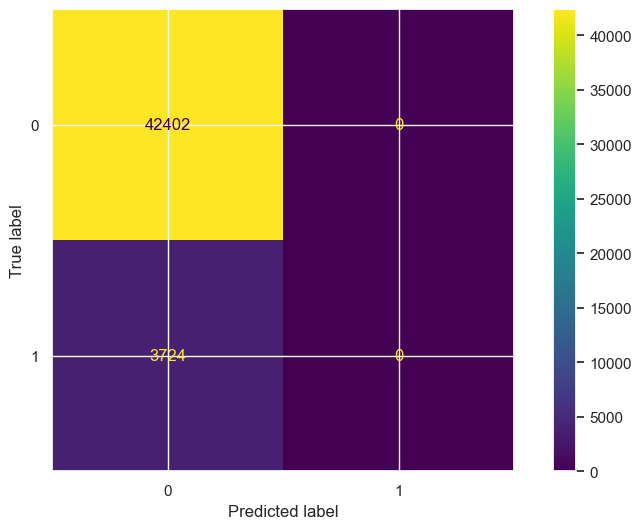

In [106]:
%%time

# Dummy estimator
with mlflow.start_run(run_name='Dummy_Estimator'): #experiment_id= experiment_id
    dummy_pipe.fit(X_train, y_train)
    
    y_pred_proba = dummy_pipe.predict_proba(X_test)
    y_pred = dummy_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    # Log params
    # mlflow.log_param('max_iter' , '100')
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(regLog_pipe, 'pipeline Dummy Estimator', signature=signature)
    #generate_auc_roc_curve(logReg,X_test, y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}

2023/06/27 23:21:29 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001821A13F7D0>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/06/27 23:21:29 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

AUC: 0.7479428396741313
CPU times: total: 1min 25s
Wall time: 39.3 s


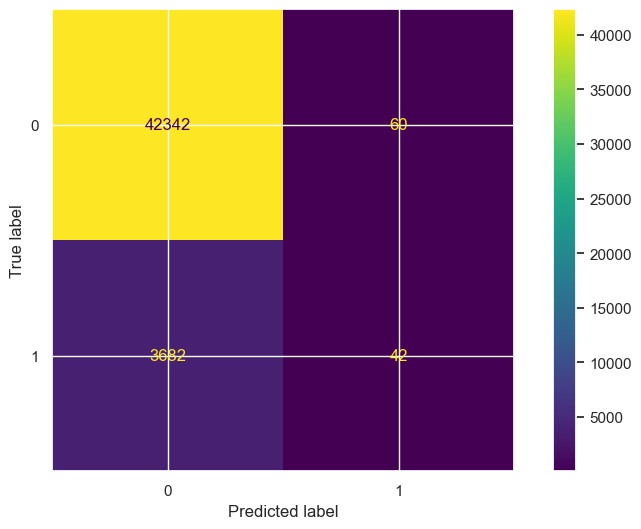

In [107]:
%%time
# premier run
with mlflow.start_run(run_name='Reg_logistic_0'): #experiment_id= experiment_id
    regLog_pipe.fit(X_train, y_train)
    
    y_pred_proba = regLog_pipe.predict_proba(X_test)
    y_pred = regLog_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    # Log params
    # mlflow.log_param('max_iter' , '100')
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(regLog_pipe, 'pipeline Regression Logistic', signature=signature)
    #generate_auc_roc_curve(logReg,X_test, y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}
    run_idrlog = mlflow.active_run().info.run_id

2023/06/27 23:22:09 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001821A13CF90>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/06/27 23:22:09 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

AUC: 0.7652637868803283


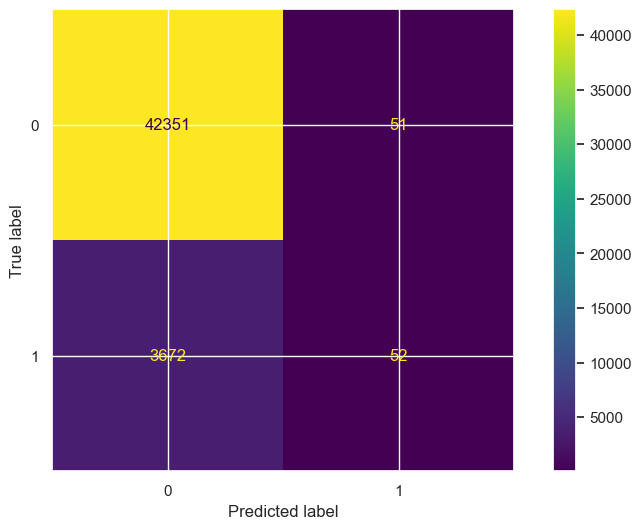

In [108]:
# premier run
with mlflow.start_run(run_name='HistGradientBoosting_0'): #experiment_id= experiment_id
    HistGB_pipe.fit(X_train, y_train)
    
    y_pred_proba = HistGB_pipe.predict_proba(X_test)
    y_pred = HistGB_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    # Log params
    # mlflow.log_param('max_iter' , '100')
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(HistGB_pipe, 'pipeline HistGradient Boosting', signature=signature)
    #generate_auc_roc_curve(logReg,X_test, y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}
    
    run_idHistGB = mlflow.active_run().info.run_id

2023/06/27 23:22:55 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000018201EBC2D0>),
                                ('disc',
                                 Pipeline(steps=[('impDiscret',
                                                  SimpleIm...`
2023/06/27 23:22:55 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impNumerical',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object 

AUC: 0.7646176074117657


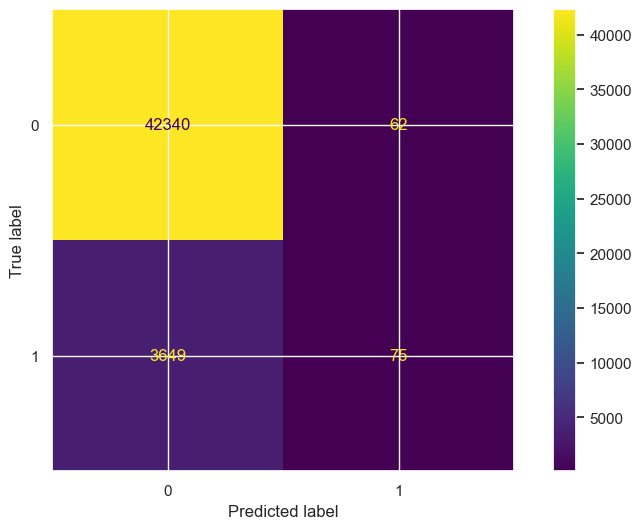

In [109]:
# premier run
with mlflow.start_run(run_name='LightGBM_0'): #experiment_id= experiment_id
    LGBM_pipe.fit(X_train, y_train)
    
    y_pred_proba = LGBM_pipe.predict_proba(X_test)
    y_pred = LGBM_pipe.predict(X_test)
    
    # Metrics
    accuracy, precision, f1, recall, auc = eval_metrics(y_test,y_pred, y_pred_proba)
    cm = ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred)
    print("AUC:", auc)
    # Log params
    # mlflow.log_param('max_iter' , '100')
    
    # Log metrics
    mlflow.log_metric("accuracy_test",accuracy)
    mlflow.log_metric('precision_test',precision)
    mlflow.log_metric("f1_test",f1)
    mlflow.log_metric("recall_test",recall)
    mlflow.log_metric("auc_test",auc)
    
    # Log figure
    mlflow.log_figure(cm.figure_, 'test_confusion_matrix.png')
    
    # Log model
    mlflow.sklearn.log_model(LGBM_pipe, 'pipeline Light Gradient Boosting', signature=signature)
    #generate_auc_roc_curve(logReg,X_test, y_test)
    #metrics = {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2)}
    
    run_idlgbm = mlflow.active_run().info.run_id

</Br>

</Br>

### <a name="C52"><font color='blue'>V.2 Model Registry (Registre de modèle) </font></a>

Le Model Registry (registre de modèles) est un composant de MLflow qui permet de gérer des versions de modèles de Machine Learning, en proposant également des stages (états).

* Le tag staging correspond à un modèle considéré comme pré-production.
* Le tag production correspond à un modèle qui serait en environnement de production.
* Le tag archived pour les anciens modèles archivés.

C'est un composant particulièrement utile pour gérer le cycle de vie des modèles, car le cycle staging, production et archive est couramment appliqué lorsque des modèles sont mis à jour régulièrement. Sous MLflow, l'onglet Models permet d'afficher tous les modèles enregistrés.

###  Enregistrement d'un modèle</font></Br>
1. Dans la page de détail des exécutions MLflow, sélectionnez un modèle MLflow enregistré dans la section Artefacts.</Br>
2. Cliquez sur le bouton Enregistrer le modèle .
</Br></Br>
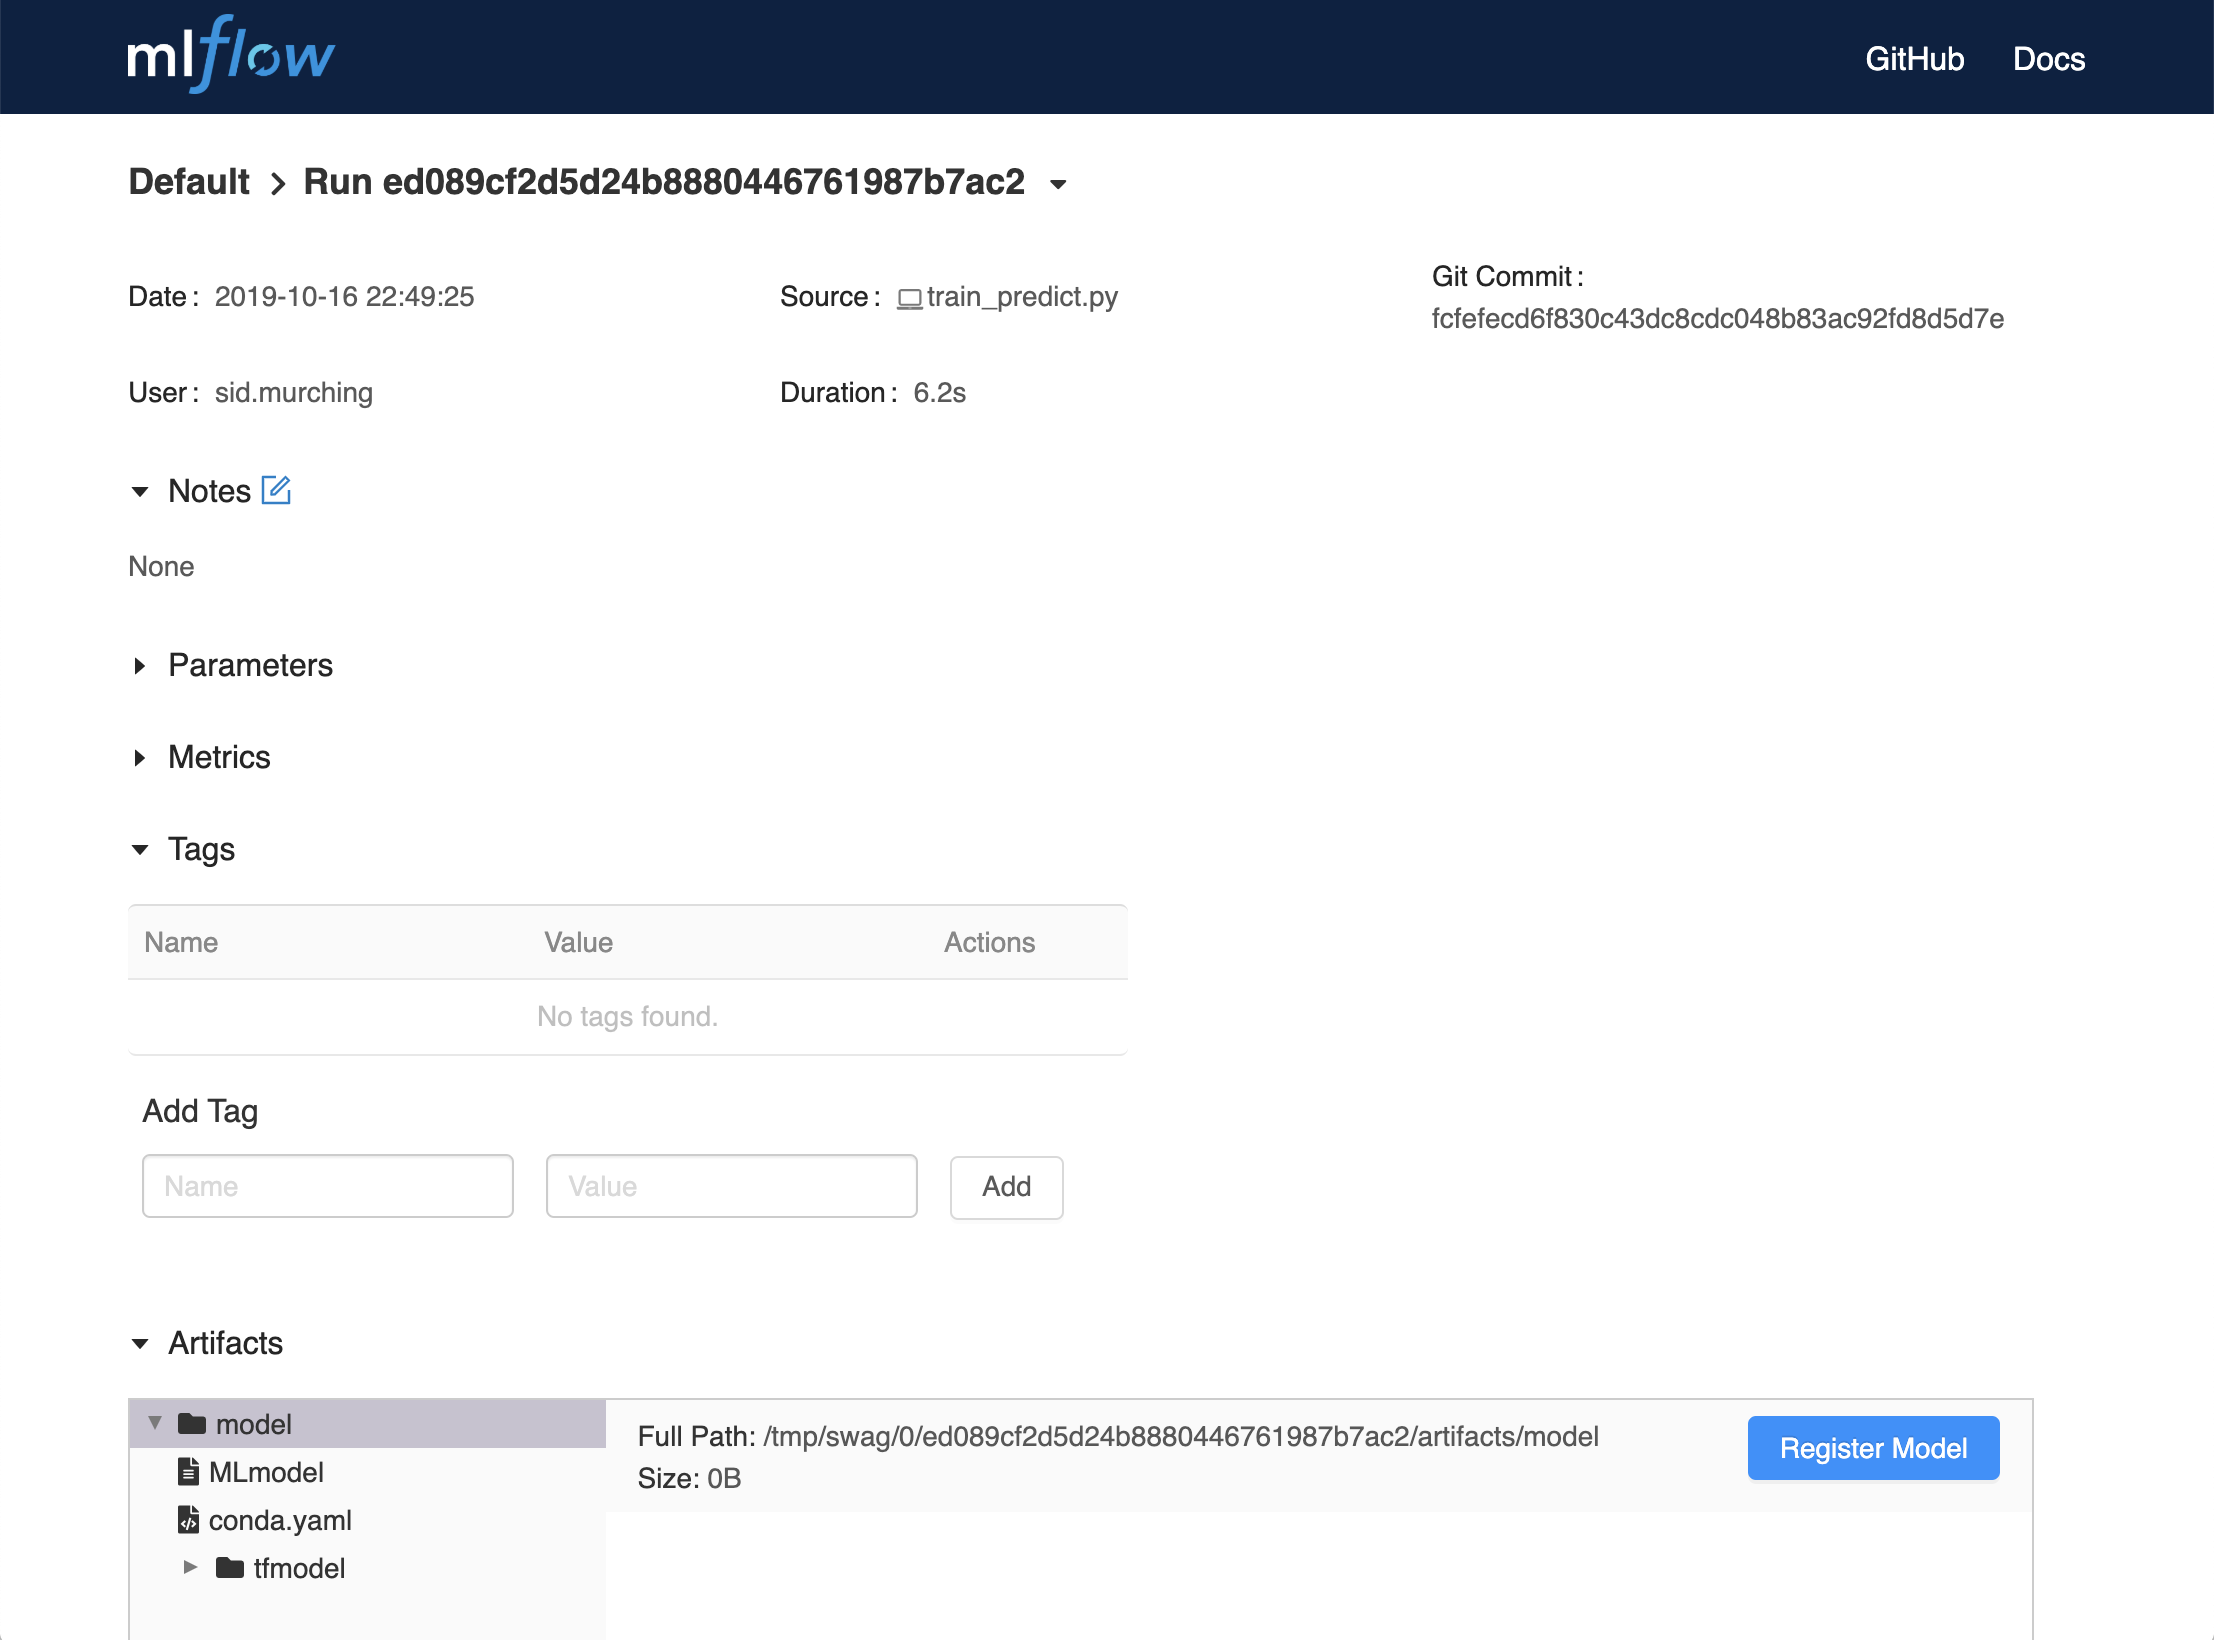

 3. Dans le champ Nom du modèle , si vous ajoutez un nouveau modèle, spécifiez un nom unique pour identifier le modèle. Si vous enregistrez une nouvelle version d'un modèle existant, sélectionnez le nom du modèle existant dans la liste déroulante.
</Br></Br>
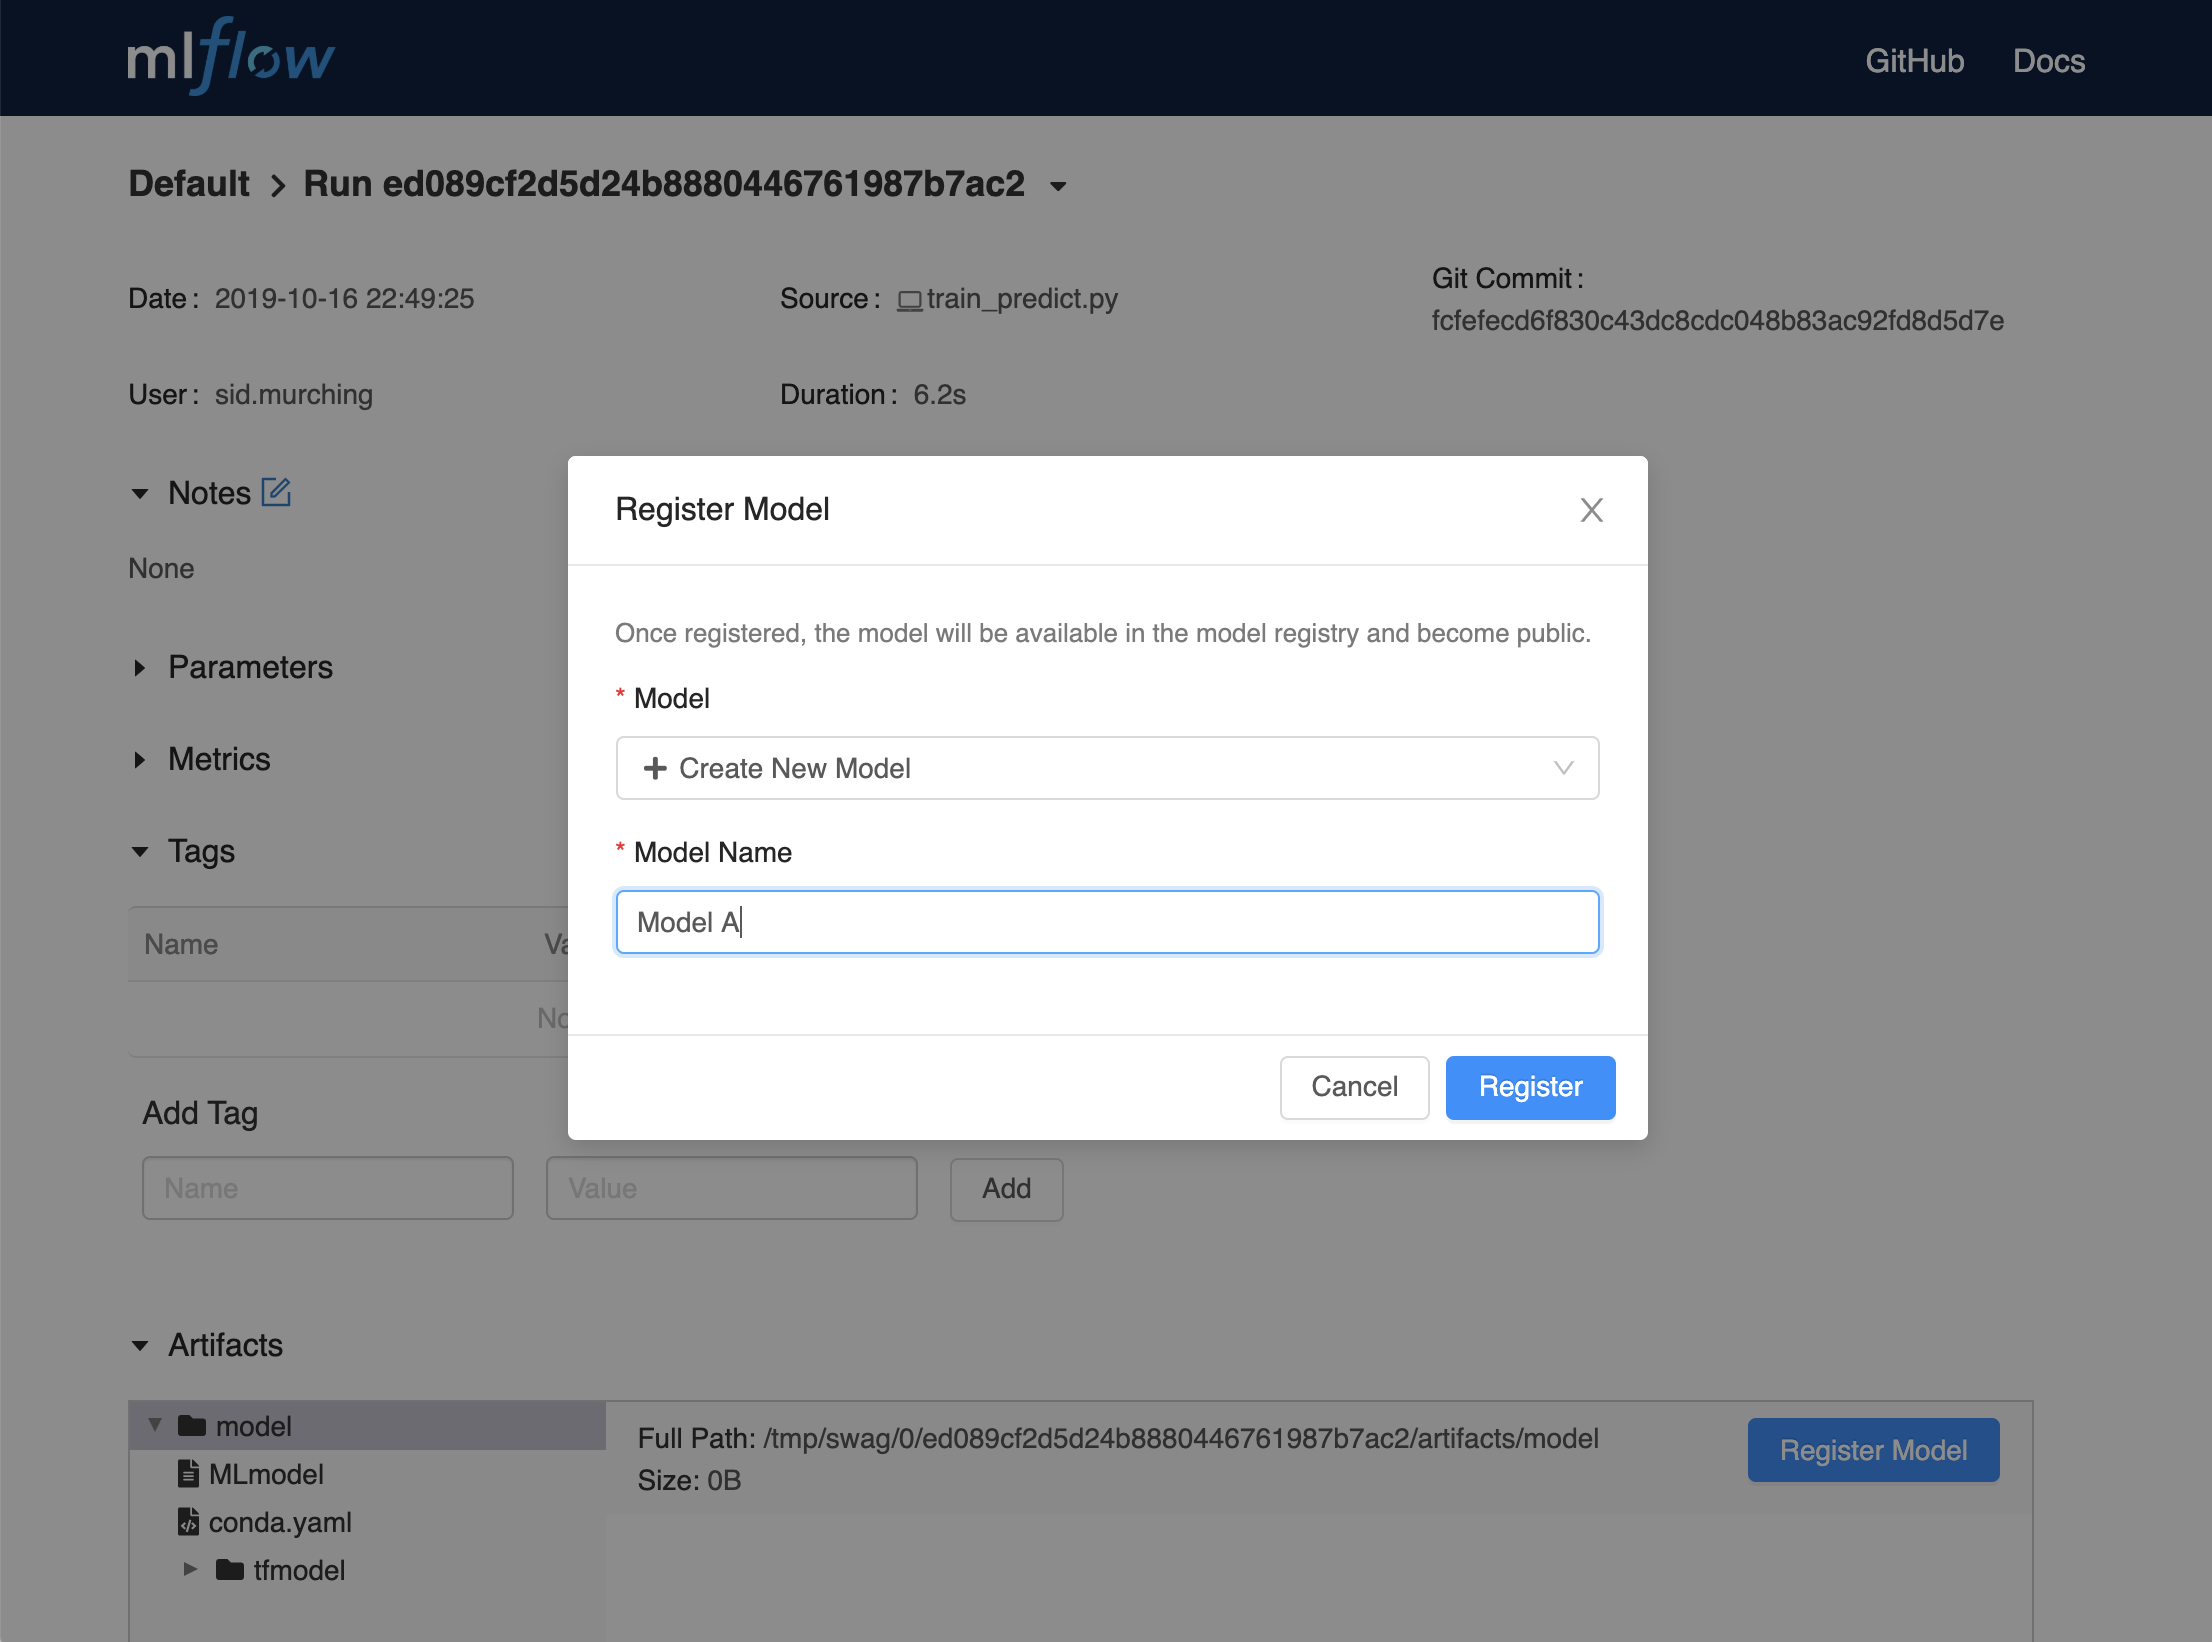

### Utilisation du registre modèle
* Accédez à la page Modèles enregistrés et affichez les propriétés du modèle.
</Br></Br>
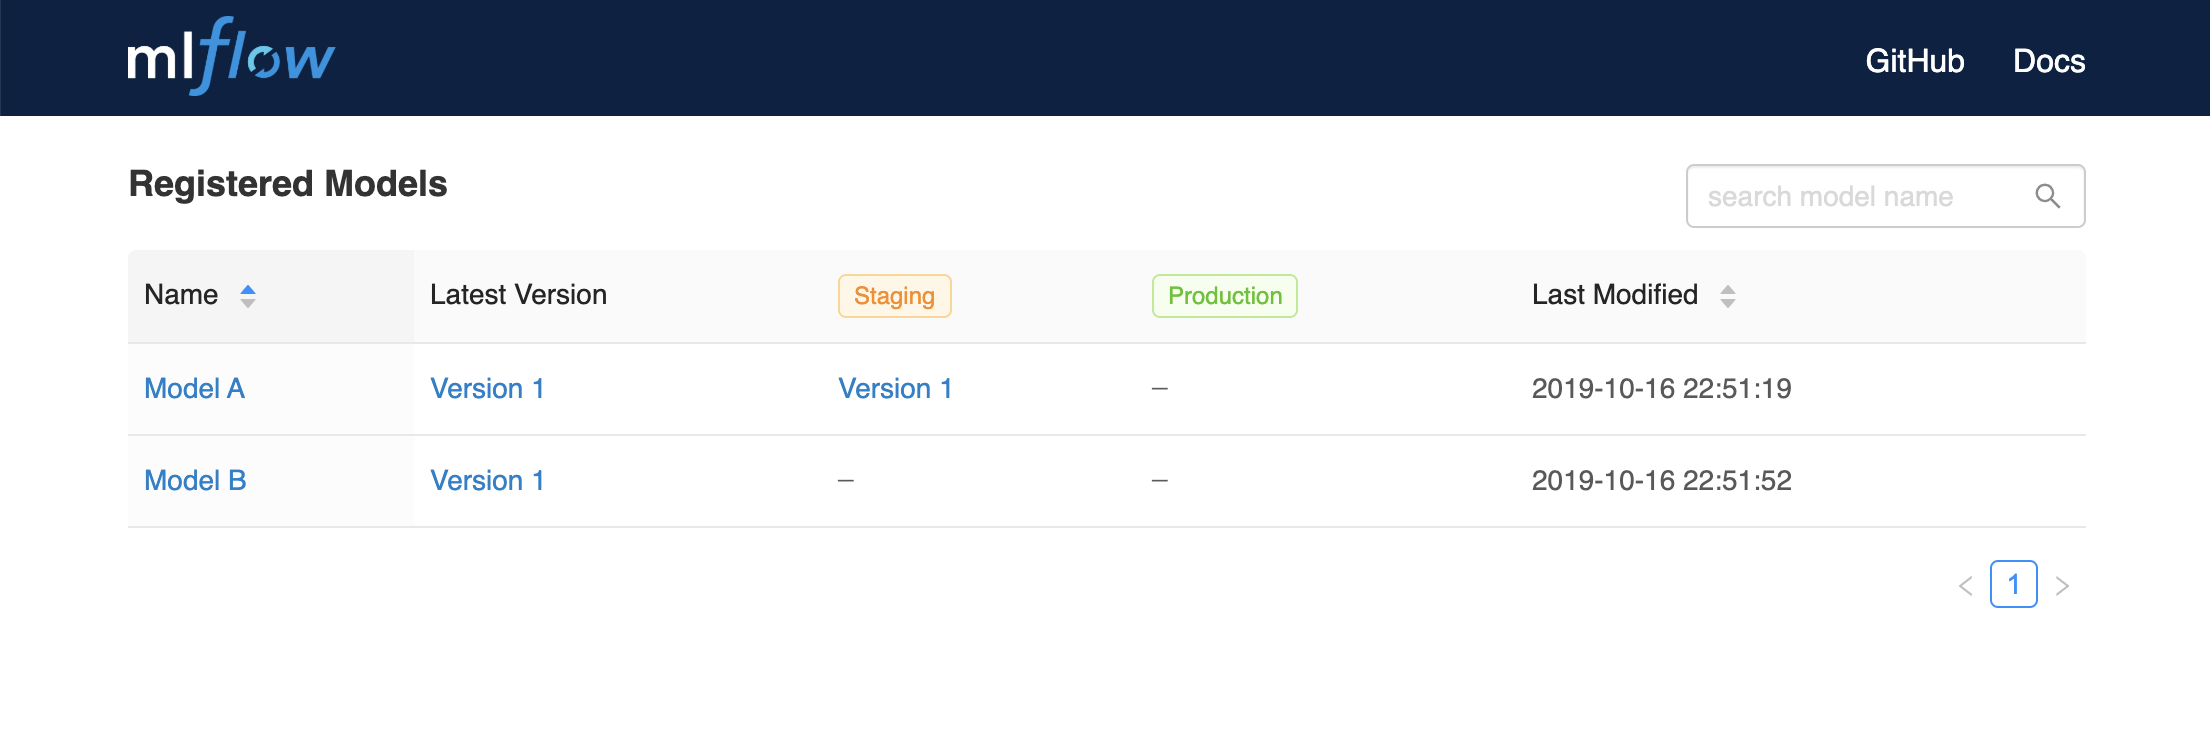

* Accédez à la section Artefacts de la page de détail de l'exécution, cliquez sur le modèle, 
* puis cliquez sur la version du modèle en haut à droite pour afficher la version que vous venez de créer.
</Br></Br>
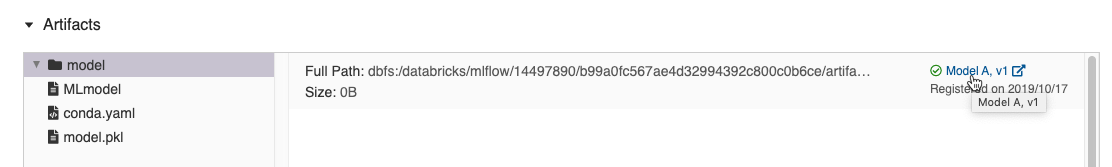

### <a name="C53"><font color='blue'>V.3 Déploiement d'une API REST </font></a>

Les commandes suivantes sont à lancer **depuis le terminal** associé à votre environnement Python.

<img src='../Cours et ressources/logo_oc.png' width=15px /> À partir du modèle MLflow, vous n'êtes plus qu'à une commande de lancer un serveur pour votre API REST ([documentation](https://mlflow.org/docs/latest/models.html#deploy-mlflow-models)).</Br> 
À vous de jouer ! [(en cas de blocage)](https://mlflow.org/docs/latest/cli.html#mlflow-models-serve)

<img src='../Cours et ressources/logo_oc.png' width=15px />  Écrivez la requête curl pour envoyer une requête. Faites attention aux guillemets :)

In [90]:
import streamlit
streamlit

<module 'streamlit' from 'C:\\Users\\eleor\\anaconda3\\envs\\py3_9_projet7_OC_DS\\lib\\site-packages\\streamlit\\__init__.py'>